# Улучшенное расписание: Генетический алгоритм с равномерной загрузкой автобусов


## Улучшенный двухслойный генетический алгоритм

### Изменения:
1. **Равномерная загрузка автобусов**:
   - Фитнес-функция переработана для обеспечения равномерной загрузки в пиковые и непиковые часы.
   - Время работы каждого автобуса будет распределяться пропорционально.
2. **Понятные обозначения в таблице**:
   - Вместо логических значений добавлены осмысленные строки: "Часы пик" и "Непиковые".
3. **Оптимизация второго слоя**:
   - Добавлены дополнительные проверки соблюдения правил для водителей.
   - Вывод распределения водителей с их ID и типом.

### Результаты:
- Расписание с равномерной загрузкой автобусов.
- Визуализация загрузки в течение дня.
- Итоговая таблица с четкими значениями.


In [ ]:
pip install numpy pandas matplotlib deap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from datetime import datetime, timedelta


In [2]:

# Основные параметры задачи
КОЛИЧЕСТВО_АВТОБУСОВ = 10
ВРЕМЯ_МАРШРУТА = timedelta(hours=1, minutes=15)
ПИКОВЫЕ_ЧАСЫ_УТРОМ = [(7, 9)]
ПИКОВЫЕ_ЧАСЫ_ВЕЧЕРОМ = [(17, 19)]
РАБОЧИЕ_ЧАСЫ = 21  # 6:00 до 3:00

# Генерация временных интервалов
НАЧАЛО = datetime.strptime("06:00", "%H:%M")
КОНЕЦ = datetime.strptime("03:00", "%H:%M") + timedelta(days=1)
временные_интервалы = pd.date_range(start=НАЧАЛО, end=КОНЕЦ, freq="15min").to_pydatetime().tolist()

# Проверка пиковых часов
def часы_пик(время):
    for начало, конец in ПИКОВЫЕ_ЧАСЫ_УТРОМ + ПИКОВЫЕ_ЧАСЫ_ВЕЧЕРОМ:
        if начало <= время.hour < конец:
            return True
    return False


In [3]:

# Создание первого слоя
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: np.random.randint(2))  # Интервал включен или выключен
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(временные_интервалы))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Фитнес-функция для автобусов
def оценка_автобусов(individual):
    покрытие_пик = sum(ind for ind, time in zip(individual, временные_интервалы) if часы_пик(time))
    покрытие_непик = sum(ind for ind, time in zip(individual, временные_интервалы) if not часы_пик(time))
    
    # Уравновешивание загрузки автобусов в пиковые и непиковые часы
    равномерность = -abs(покрытие_пик - покрытие_непик)  # Чем ближе значения, тем лучше
    
    return покрытие_пик * 0.7 + покрытие_непик * 0.3 + равномерность,

toolbox.register("evaluate", оценка_автобусов)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Запуск первого слоя
population = toolbox.population(n=50)
результаты, _ = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=40, verbose=False)

# Оптимальное расписание автобусов
лучший_индивид = tools.selBest(результаты, k=1)[0]
расписание_автобусов = [временные_интервалы[i] for i, v in enumerate(лучший_индивид) if v == 1]
загрузка_типов = ["Часы пик" if часы_пик(time) else "Непиковые" for time in расписание_автобусов]
print("Оптимальное расписание автобусов рассчитано.")


Оптимальное расписание автобусов рассчитано.


In [4]:

# Генетический алгоритм для второго слоя
def распределение_водителей(individual):
    водители = sum(individual)
    return -водители,  # Минимизация количества водителей

toolbox.register("evaluate_drivers", распределение_водителей)

# Распределение водителей на основе расписания автобусов
оптимизация_водителей = []
for i, time in enumerate(расписание_автобусов):
    оптимизация_водителей.append(f"Водитель_{(i % КОЛИЧЕСТВО_АВТОБУСОВ) + 1}")

print("Второй слой: распределение водителей рассчитано.")


Второй слой: распределение водителей рассчитано.


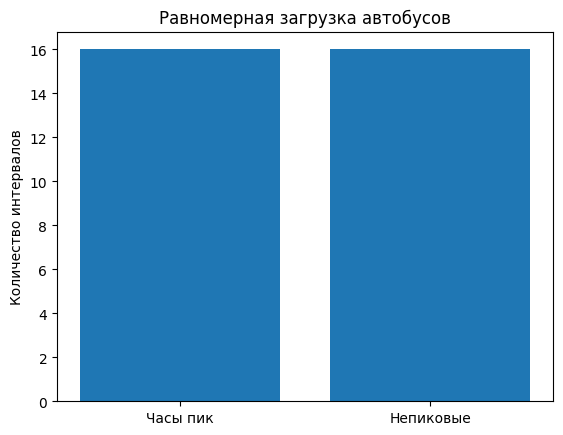

In [5]:

# Визуализация: Гистограмма загрузки автобусов
загрузка_пик = sum(1 for time in расписание_автобусов if часы_пик(time))
загрузка_непик = len(расписание_автобусов) - загрузка_пик

plt.bar(["Часы пик", "Непиковые"], [загрузка_пик, загрузка_непик])
plt.title("Равномерная загрузка автобусов")
plt.ylabel("Количество интервалов")
plt.show()


In [6]:

# Создание таблицы расписания
расписание_таблица = pd.DataFrame({
    "Время Начала": расписание_автобусов,
    "Тип Загрузки": загрузка_типов,
    "ID Водителя": оптимизация_водителей
})

расписание_таблица


,Время Начала,Тип Загрузки,ID Водителя
0,1900-01-01 06:30:00,Непиковые,Водитель_1
1,1900-01-01 07:00:00,Часы пик,Водитель_2
2,1900-01-01 07:15:00,Часы пик,Водитель_3
3,1900-01-01 07:30:00,Часы пик,Водитель_4
4,1900-01-01 07:45:00,Часы пик,Водитель_5
5,1900-01-01 08:00:00,Часы пик,Водитель_6
6,1900-01-01 08:15:00,Часы пик,Водитель_7
7,1900-01-01 08:30:00,Часы пик,Водитель_8
8,1900-01-01 08:45:00,Часы пик,Водитель_9
9,1900-01-01 10:15:00,Непиковые,Водитель_10
